In [3]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 6.9 MB/s  0:00:00 eta 0:00:01

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

In [3]:
features = [
'A1b',
'B6',
'C2',
'C3a',
'C9',
'C42b',
'C50f',
'C57',
'D2b',
'D3a',
'D5',
'E9a',
'E13a',
'E13b',
'E17a',
'E18a',
'E18b',
'E20a',
'F8',
'F13',
'F14',
'F15',
'F24',
'F37',
'H5',
'J11',
'J13',
'J14',
'L26a',
'G1',
'G2',
'G8',
'G13',
'I4d',
'I11a',
'I11b',
'FFQ8',
'FFQ10',
'FFQ15',
'FFQ32',
'FFQ50',
'FFQ56',
'FFQ68',
'hAPAQ12',
'hAPAQ14',
'EduC',
'MedDietScore',
'WEIGHT',
'HEIGHT',
'AgeC']

In [4]:
import pandas as pd
df = pd.read_csv("data_pre_proc.csv", header=0)
df.dropna(subset=['ZCO'], inplace=True)

In [5]:
X = df[features]
Y = df["ZCO"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training samples: 1232, Test samples: 309
Number of features: 50


In [7]:
discrete_cols = []
continuous_cols = []

for col in X_train.columns:
    n_unique = X_train[col].nunique(dropna=True)
    if (n_unique <= 10) or (X_train[col].dtype in ['int64', 'int32', 'int16', 'int8', 'bool']):
        discrete_cols.append(col)
    else:
        continuous_cols.append(col)

print(f"{len(discrete_cols)} discrete and {len(continuous_cols)} continuous features")

39 discrete and 11 continuous features


In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge

X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

if discrete_cols:
    print(f"Imputing discrete features ({len(discrete_cols)} columns)...")
    disc_imputer = SimpleImputer(strategy='most_frequent')
    
    # Fit on train, transform both
    X_train_discrete = disc_imputer.fit_transform(X_train[discrete_cols])
    X_test_discrete = disc_imputer.transform(X_test[discrete_cols])
    
    # Update DataFrames
    X_train_imputed[discrete_cols] = X_train_discrete
    X_test_imputed[discrete_cols] = X_test_discrete

if continuous_cols:
    print(f"Imputing continuous features ({len(continuous_cols)} columns) with IterativeImputer...")
    cont_imputer = IterativeImputer(
        estimator=BayesianRidge(),
        max_iter=10,
        random_state=42,
        initial_strategy='mean'
    )
    X_train_continuous = cont_imputer.fit_transform(X_train[continuous_cols])
    X_test_continuous = cont_imputer.transform(X_test[continuous_cols])
    
    X_train_imputed[continuous_cols] = X_train_continuous
    X_test_imputed[continuous_cols] = X_test_continuous

train_nan = X_train_imputed.isna().sum().sum()
test_nan = X_test_imputed.isna().sum().sum()

if train_nan == 0 and test_nan == 0:
    print("Imputation successful! No missing values remain.")
else:
    print(f"Warning: {train_nan} train and {test_nan} test NaN remain")

Imputing discrete features (39 columns)...
Imputing continuous features (11 columns) with IterativeImputer...
Imputation successful! No missing values remain.


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [11]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,       # Many trees, but stop early
    learning_rate=0.01,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    early_stopping_rounds=50,
    random_state=42
)

In [12]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [14]:
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = evaluate_model(y_train, y_pred_train, "Training")
test_metrics = evaluate_model(y_test, y_pred_test, "Test")


Training Metrics:
MSE: 0.1858
RMSE: 0.4310
MAE: 0.3234
R² Score: 0.7408

Test Metrics:
MSE: 0.2537
RMSE: 0.5037
MAE: 0.3749
R² Score: 0.6319


<Figure size 1000x800 with 0 Axes>

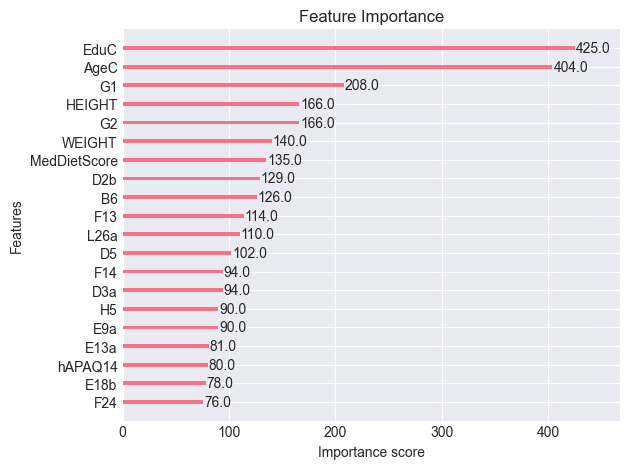


Top 10 Features:
         feature  importance feature_name
45          EduC       425.0          NaN
49          AgeC       404.0          NaN
29            G1       208.0          NaN
30            G2       166.0          NaN
48        HEIGHT       166.0          NaN
47        WEIGHT       140.0          NaN
46  MedDietScore       135.0          NaN
8            D2b       129.0          NaN
1             B6       126.0          NaN
19           F13       114.0          NaN


In [15]:
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=20, importance_type='weight')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Get feature importance as dataframe
importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
feature_importance = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
}).sort_values('importance', ascending=False)

# Map feature indices to names if needed
feature_mapping = {f'f{i}': name for i, name in enumerate(X_train.columns)}
feature_importance['feature_name'] = feature_importance['feature'].map(feature_mapping)

print("\nTop 10 Features:")
print(feature_importance.head(10))

In [97]:
# learning_rate=0.01,
# max_depth=3,
# subsample=0.7,
# colsample_bytree=0.7,
# early_stopping_rounds=50

X_train_fit, X_val, y_train_fit, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

param_grid = {
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_tuned = xgb.XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1, early_stopping_rounds=50, verbosity=0)

grid_search = GridSearchCV(
    xgb_tuned,
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_fit, y_train_fit, eval_set=[(X_val, y_val)])

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

[0]	validation_0-rmse:0.79059
[0]	validation_0-rmse:0.79055
[0]	validation_0-rmse:0.79011
[1]	validation_0-rmse:0.78697
[0]	validation_0-rmse:0.79003
[0]	validation_0-rmse:0.78985
[1]	validation_0-rmse:0.78615
[0]	validation_0-rmse:0.79003
[1]	validation_0-rmse:0.78736
[1]	validation_0-rmse:0.78628
[0]	validation_0-rmse:0.79019
[2]	validation_0-rmse:0.78371
[1]	validation_0-rmse:0.78591
[1]	validation_0-rmse:0.78610
[0]	validation_0-rmse:0.78995
[2]	validation_0-rmse:0.78377
[2]	validation_0-rmse:0.78229
[1]	validation_0-rmse:0.78643
[2]	validation_0-rmse:0.78218
[3]	validation_0-rmse:0.78002
[2]	validation_0-rmse:0.78191
[3]	validation_0-rmse:0.77812
[3]	validation_0-rmse:0.77850
[2]	validation_0-rmse:0.78295
[4]	validation_0-rmse:0.77541
[2]	validation_0-rmse:0.78269
[3]	validation_0-rmse:0.77815
[1]	validation_0-rmse:0.78587
[4]	validation_0-rmse:0.77423
[5]	validation_0-rmse:0.77195
[3]	validation_0-rmse:0.77867
[3]	validation_0-rmse:0.77900
[4]	validation_0-rmse:0.77421
[2]	valida

In [98]:
best_model = grid_search.best_estimator_

best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train)],  # Optional: for monitoring
    verbose=False
)

predictions = best_model.predict(X_test)

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, predictions)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, predictions)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, predictions)

print("Training Performance")
print("_" * 60)
print(f"RMSE:  {train_rmse:.4f}")
print(f"MSE:   {train_mse:.4f}")
print(f"MAE:   {train_mae:.4f}")
print(f"R²:    {train_r2:.4f}")

print("-" * 60)

print("Prediction Performance")
print("_" * 60)
print(f"RMSE:  {test_rmse:.4f}")
print(f"MSE:   {test_mse:.4f}")
print(f"MAE:   {test_mae:.4f}")
print(f"R²:    {test_r2:.4f}")

Training Performance
____________________________________________________________
RMSE:  0.4310
MSE:   0.1858
MAE:   0.3234
R²:    0.7408
------------------------------------------------------------
Prediction Performance
____________________________________________________________
RMSE:  0.5240
MSE:   0.2745
MAE:   0.3879
R²:    0.6017



Top 10 Feature Importances:
   feature  importance
21     F15    0.148920
20     F14    0.144270
30      G2    0.103557
19     F13    0.085835
45    EduC    0.076822
29      G1    0.062165
32     G13    0.046273
33     I4d    0.031688
49    AgeC    0.020093
25     J11    0.019115


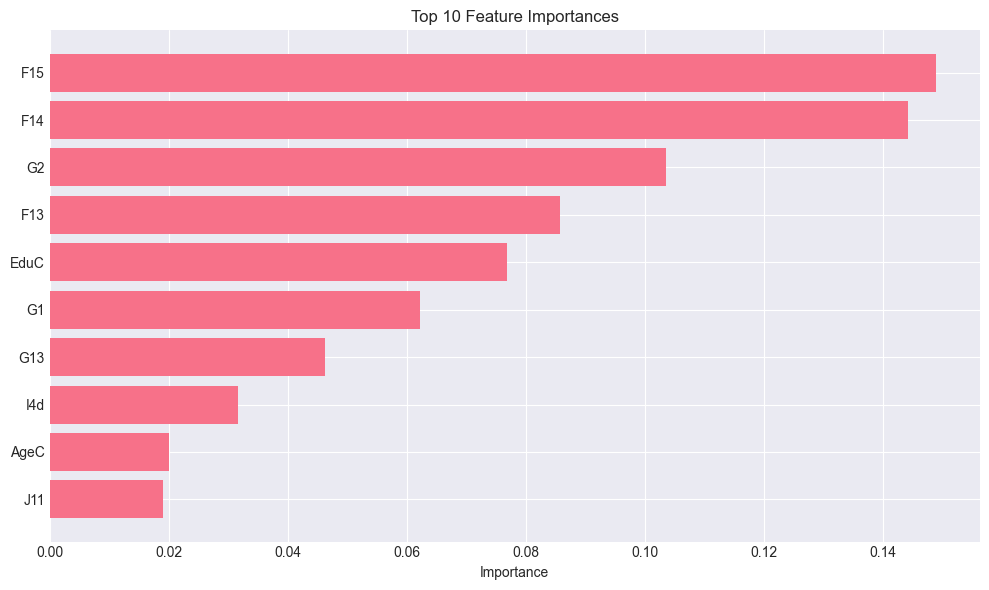

In [101]:
best_model = grid_search.best_estimator_

if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(importance_df.head(10))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['feature'], importance_df.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

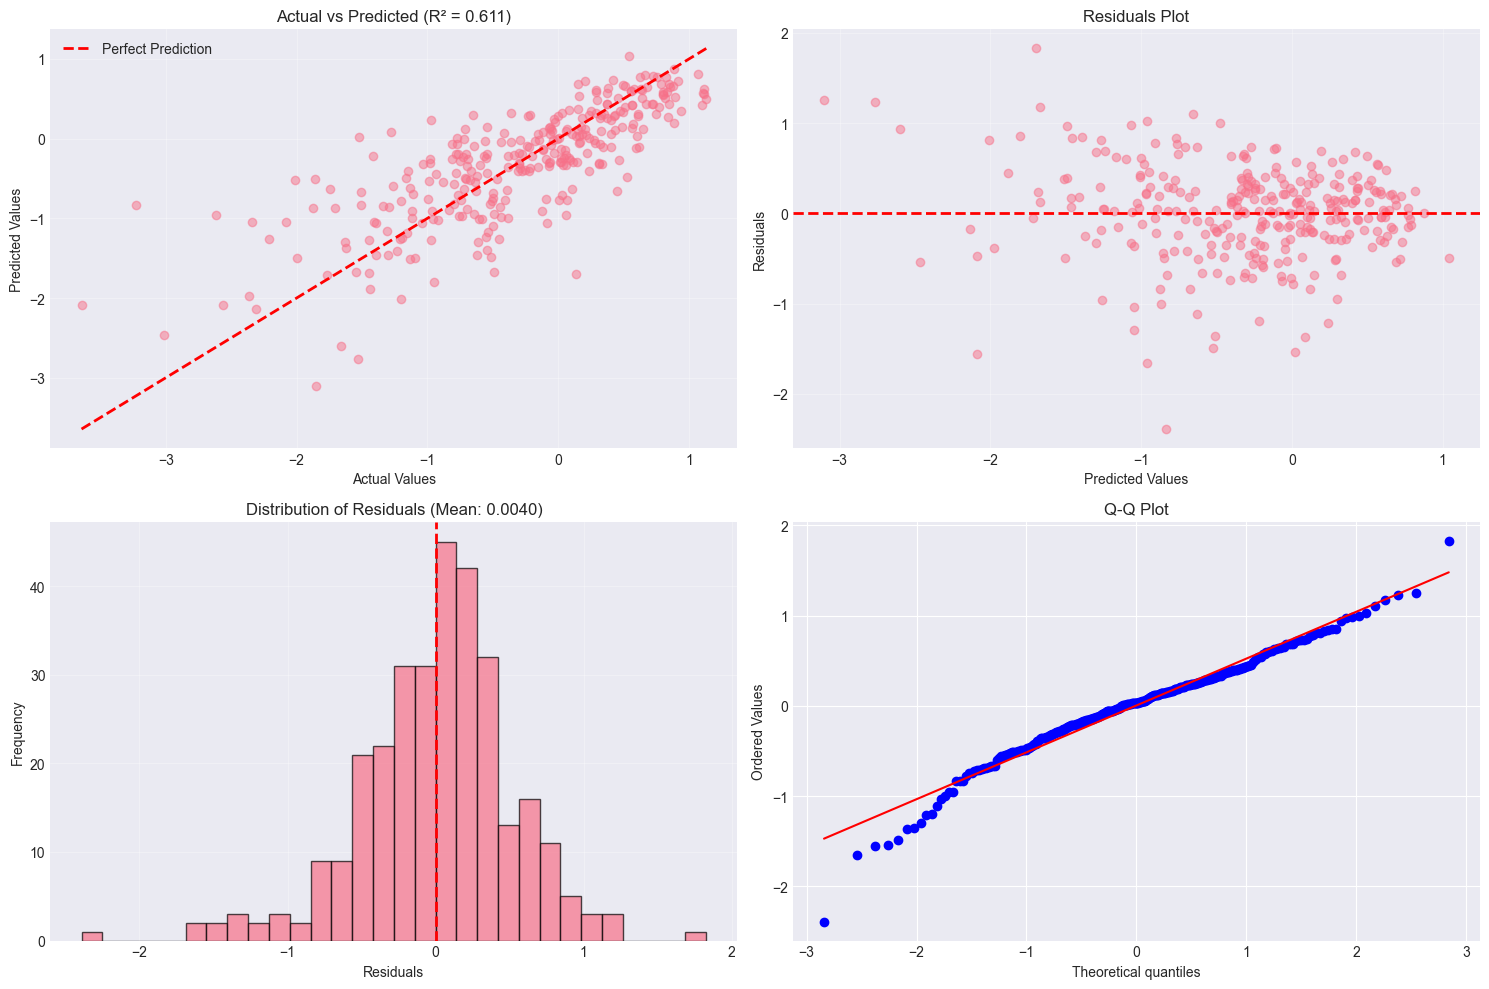

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(y_test, predictions, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {r2:.3f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

residuals = y_test - predictions
axes[0, 1].scatter(predictions, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals Plot')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Distribution of Residuals (Mean: {residuals.mean():.4f})')
axes[1, 0].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()